## Stochastic SFHs

In a series of papers, Daniel Kenson et al. describe how a few observables can be fit if the star formation histories are descreibed simply as a $H=1$ stochatsic process, see references below.

Here we take their 100k stochastic process generated as such and take transform these in SFHs by proper physical normalization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import interp1d

from astropy.io import fits

In [2]:
# Assumptions here
# Planck18 cosmology
# MIST/MILES through FSPS for stellar populations
Zsun = 0.019 # For MILES library
metal = .1 * Zsun # Let's investigate the inflluence of this at some point.
z_init = 15 # Redshift at which SF commences
z_final = 0 # Investigate at this redshift


In [3]:
# Get data
# This files contain dimensionless 100k tracks of H=1 stochastic processes, at 10k time steps
stoch_file = 'H100Sk10000.fits'
with fits.open(stoch_file) as hdul:
    header = hdul[0].header
    stoch_data = hdul[0].data
    print(hdul.info())
    
# For testing purposes, 11k tracks should do (to distnguish from 10k time steps)
stoch_data = stoch_data[:11_000,:]

Filename: H100Sk10000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (10000, 100000)   float32   
None


In [4]:
stoch_data.shape

(11000, 10000)

In [5]:
# Get cosmology from astropy as well.
from astropy.cosmology import Planck18 as cosmo
print(f'H_0 = {cosmo.H0}, age of the universe at z=0: {cosmo.age(0):3.2f}.')

H_0 = 67.66 km / (Mpc s), age of the universe at z=0: 13.79 Gyr.


In [6]:
# Normalize all tracks such that sum of all timesteps is 1. To make them masses/SFHs, multiply by final mass (and divide by timesteps).
norm = stoch_data / stoch_data.sum(axis=1).reshape(stoch_data.shape[0], 1)
cum = norm.cumsum(axis=1)
norm.shape

(11000, 10000)

In [7]:
# Determine timesteps from cosmology
age_final = cosmo.age(z_final)
age_init = cosmo.age(z_init)
tstep = ((age_final - age_init).value * 1e9)/norm.shape[1] # in years, should be about a million 

Text(0, 0.5, '$M / M_{final}$')

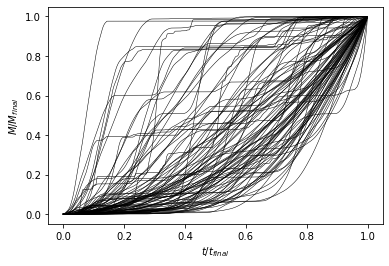

In [8]:
for i in np.random.randint(0, cum.shape[0], 100):
    plt.plot(np.arange(cum.shape[1])/cum.shape[1], cum[i,:], color='black', linewidth=0.5)
plt.xlabel('$t/t_{final}$')
plt.ylabel('$M / M_{final}$')

# SFHs of MW-mass galaxies
OK, let's pick a final mass, generate histories and count PSBs, just for fun.

Disk mass of MW according to: https://arxiv.org/abs/1407.1078 (Timothy C. Licquia, Jeffrey A. Newman):
5.17 ± 1.11×10$^{10}$ M$_⊙$


In [9]:
target_Mass = 5.2e10 # First as FORMED MASS, not the same as current mass! Correct for stellar evolution later
masses = norm*target_Mass


del norm
del stoch_data

# Mass evolution of "SSPs"
From population synthesis code, get the fraction of the mass that still exists after some time t. With that, the very different SFHs can be normalized such that they end up with the same _current_ mass.
Assumption here: fraction of FORMED mass is given by the stochastic trajectories, fraction of that that is still in stars at time of "observation" given by SSP of _some_ metallicity (.1 $Z_{solar}$? perhaps make it a function of t_universe), so we can calculate an overall re-normalization (must be overall, or the track would not be the stochastic realisation) by renormalizing on the fraction of stellar mass lost.

In [10]:
import fsps

In [11]:
# Population synthesis parameters
imf_type = 1  # Chabrier 2003
SFH_ind = 0   # SSP - just for normalization of SFHs. AFter that, use tabelized SFH (SFH_ind = 3, plus provided tables of SFH)

SSP = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, imf_type=imf_type,
                                sfh=SFH_ind, logzsol=np.log10(metal/Zsun), dust_type=2, dust2=0.2)
SSP.libraries

(b'mist', b'miles', b'DL07')

In [12]:
# For a list of ages, Get fraction of mass still present, to interpolate later 
# (no need to do this 10k times)
nsteps = 100
mass_fraction = [1]
ages = [0]
for age_SSP in np.linspace(1e-5, (age_final-age_init).value, nsteps):
    ages.append(age_SSP)
    wav, spec = SSP.get_spectrum(tage=age_SSP)
    mass_fraction.append(SSP.stellar_mass)


In [13]:
# Clean up SSP object
del SSP

Text(0, 0.5, 'Fraction of total formed stellar mass still in stars')

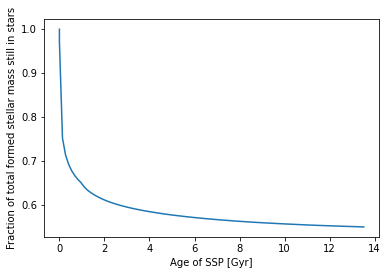

In [14]:
# Interpolation function and a quick plot
frac_mass = interp1d(ages, mass_fraction, kind='linear')
plt.plot(ages, mass_fraction)
plt.xlabel('Age of SSP [Gyr]')
plt.ylabel('Fraction of total formed stellar mass still in stars')

In [15]:
# Renormalize SFHs such that total mass surviving becomes the target mass,
# rather than the integral of the SFH (=total stellar mass ever formed)

# Factor per timestep the same for all
age_of_gal = (np.arange(masses.shape[1])*tstep / 1e9)
fmass = frac_mass(age_of_gal)

mass_retained = masses * fmass
total_mass_retained = mass_retained.sum(axis=1)

# Rescaling to have all SFHs again converge to the target mass

masses = mass_retained * (target_Mass/total_mass_retained).reshape(masses.shape[0],1)
mass_retained = 0   # Gargbage collection

In [16]:
print(f'After renormalization, standard deviation of current stellar mass: {masses.sum(axis=1).std():.2f}')

After renormalization, standard deviation of current stellar mass: 0.00


In [17]:
# Total mass formed now simply is current mass in every timestep, 
# corrected "the other way" per time step, summed.
total_mass_formed = (masses / fmass).sum(axis=1)

Text(10.7210033436348, 7.45174724195157, 'Surviving stellar mass today')

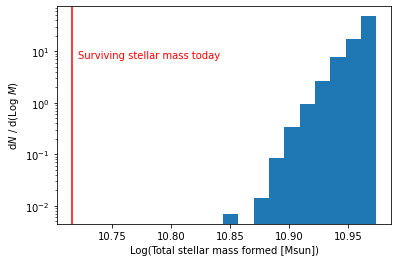

In [18]:
plt.hist(np.log10(total_mass_formed), density=True)
plt.semilogy()
yl = plt.ylim()
plt.vlines(np.log10(target_Mass), yl[0],yl[1], color='red')
plt.ylim(yl)
plt.xlabel('Log(Total stellar mass formed [Msun])')
plt.ylabel('d$N$ / d(Log $M$)')
plt.text(np.log10(target_Mass)+.005, yl[1]*.1, 'Surviving stellar mass today', color='red')

In [19]:
# Star formation rate is stellar mass formed per time step
SFR = (masses/(fmass*tstep))

Text(0.5, 1.0, 'Star Formation History')

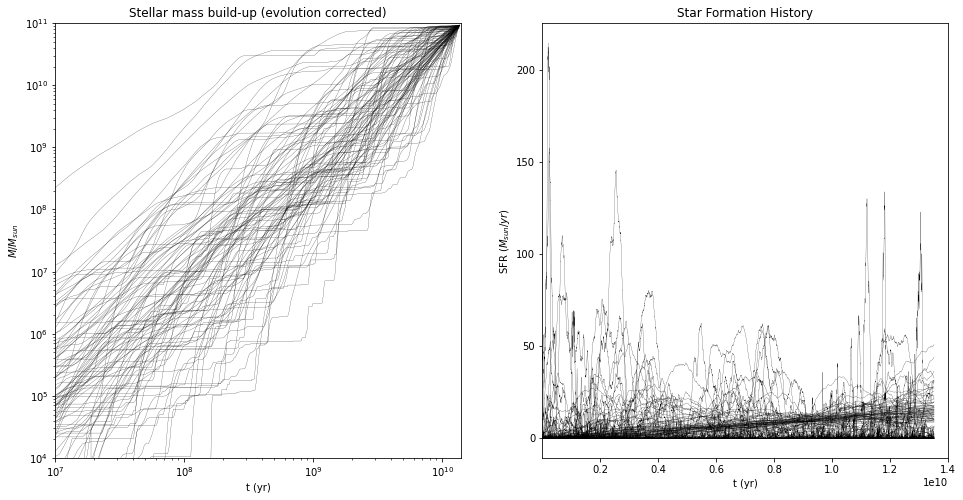

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(121)
inds = np.random.randint(0, masses.shape[0], 100)
for i in inds:
    plt.plot(np.arange(masses.shape[1])*tstep+age_init.value, (SFR[i,:]*tstep).cumsum(), c='k', linewidth=.2)
plt.semilogy()
plt.semilogx()
plt.xlim([1e7, 1.4e10])
plt.ylim([1e4, 1e11])

plt.xlabel('t (yr)')
plt.ylabel('$M / M_{sun}$')
plt.title('Stellar mass build-up (evolution corrected) NOT QUITE!')
plt.subplot(122)
for i in inds:
    plt.plot(np.arange(masses.shape[1])*tstep+age_init.value, (SFR[i,:]), c='k', linewidth=.2)
plt.xlim([1e7, 1.4e10])
# plt.semilogx()
plt.xlabel('t (yr)')
plt.ylabel('SFR ($M_{sun}/yr)$')
plt.title('Star Formation History')

## Detecting PSBs

For PSBs at the present time, we need the galaxy to be inactive (sSFR < ...) and we need them to to have been actively SF forming (sSFR > ... ) at most XXX???XXX 600 Myr ago and to have dropped by a factor of at least ... in the mean time (in less than ... Myr).

### Notes on sSFR
The defintion of PSBs depend on specific star formation rates, defined as the SFR divided by the *current* stellar mass, so for eacht time step one needs to calculate the remaining stellar mass produced in all previous timesteps, which is a simple multiplication with the fraction for the corresponding age. The calculation is a bit convolved, though. For PSBs we only need to calculate the sSFR in the past ... Myr.


In [23]:
# This array will become sSFR, but isn't yet. For memory purposes we already call it that.

t_PSB = 600e6  # Time of visibility of PSBs

sSFR = SFR[:, -int(np.ceil(t_PSB/tstep)):] / masses   ## CHECK WHICH MASSES TO USE

## WORK OUT ON PAPER HOW TO DEAL WITH fmass AND cumulative products to make this simple!
# Age of stellar pop in timestep i here is len

In [24]:
sSFR.shape

(11000, 444)

In [25]:
fmass

array([1.        , 0.96989556, 0.96772007, ..., 0.55089811, 0.550896  ,
       0.55089389])

In [30]:
fracmass = fmass/np.roll(fmass, 1)
fracmass[0] = 1

In [31]:
fracmass

array([1.        , 0.96989556, 0.99775699, ..., 0.99999617, 0.99999617,
       0.99999617])

In [32]:
fracmass.cumprod()

array([1.        , 0.96989556, 0.96772007, ..., 0.55089811, 0.550896  ,
       0.55089389])

### Evolution correction is slightly more complicated

As it is now, the "evolution corrected" stuff shows the stellar mass build-up, that would survive to the present day (at that time, less mass is lost yet!).

Let's try to do better.

Small tests for smart vectorized code first.

In [4]:
# let's say this is the mass formed:
mm = np.ones((4, 5)) * np.arange(1,6).reshape(1, 5)
# Fractions lost over time, like fracmass above
ff = np.array([.9, .9, .8, .8, .7])
# so, cumulatively that looks like
cf = ff.cumprod()




array([0.9    , 0.81   , 0.648  , 0.5184 , 0.36288])